In [16]:
import enum
import math

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import zipfile
import sys
import os
import requests
import pandas as pd
import pickle
from torch.utils.data import DataLoader, Dataset

In [17]:
# show pytorch version and cuda version
print(torch.__version__)
print(torch.version.cuda)

# show python version
!python -V

2.1.0.dev20230502+cu118
11.8
Python 3.11.3


## collecting and preparing data

In [18]:
%pwd

'/work/postresearch/Shared/Projects/Farbod'

In [19]:
#change working directory
os.chdir('/work/postresearch/Shared/Projects/Farbod/')

### downloading the data (should only need to do this once)

In [20]:
# os.makedirs("data_project/", exist_ok=True)
# url = "https://www.microsoft.com/en-us/research/wp-content/uploads/2016/06/STMVL-Release.zip"
# urlData = requests.get(url).content
# filename = "data_project/STMVL-Release.zip"
# with open(filename, mode="wb") as f:
#     f.write(urlData)
# with zipfile.ZipFile(filename) as z:
#     z.extractall("data_project/pm25")
        
def create_normalizer_pm25():
    df = pd.read_csv(
        "/home/alinezhad.f/data_project/pm25/STMVL-Release/Code/STMVL/SampleData/pm25_ground.txt",
        index_col="datetime",
        parse_dates=True,
    )
    test_month = [3, 6, 9, 12]
    for i in test_month:
        df = df[df.index.month != i]
    mean = df.describe().loc["mean"].values
    std = df.describe().loc["std"].values
    path = "/home/alinezhad.f/data_project/pm25/pm25_meanstd.pk"
    with open(path, "wb") as f:
        pickle.dump([mean, std], f)
create_normalizer_pm25()

In [21]:
class PM25_Dataset(Dataset):
    def __init__(self, eval_length=36, target_dim=36, mode="train", validindex=0):
        self.eval_length = eval_length
        self.target_dim = target_dim

        path = "/home/alinezhad.f/data_project/pm25/pm25_meanstd.pk"
        with open(path, "rb") as f:
            self.train_mean, self.train_std = pickle.load(f)
        if mode == "train":
            month_list = [1, 2, 4, 5, 7, 8, 10, 11]
            # 1st,4th,7th,10th months are excluded from histmask (since the months are used for creating missing patterns in test dataset)
            flag_for_histmask = [0, 1, 0, 1, 0, 1, 0, 1] 
            month_list.pop(validindex)
            flag_for_histmask.pop(validindex)
        elif mode == "valid":
            month_list = [1, 2, 4, 5, 7, 8, 10, 11]
            month_list = month_list[validindex : validindex + 1]
        elif mode == "test":
            month_list = [3, 6, 9, 12]
        self.month_list = month_list

        # create data for batch
        self.observed_data = []  # values (separated into each month)
        self.observed_mask = []  # masks (separated into each month)
        self.gt_mask = []  # ground-truth masks (separated into each month)
        self.index_month = []  # indicate month
        self.position_in_month = []  # indicate the start position in month (length is the same as index_month)
        self.valid_for_histmask = []  # whether the sample is used for histmask
        self.use_index = []  # to separate train/valid/test
        self.cut_length = []  # excluded from evaluation targets

        df = pd.read_csv(
            "/home/alinezhad.f/data_project/pm25/STMVL-Release/Code/STMVL/SampleData/pm25_ground.txt",
            index_col="datetime",
            parse_dates=True,
        )
        df_gt = pd.read_csv(
            "/home/alinezhad.f/data_project/pm25/STMVL-Release/Code/STMVL/SampleData/pm25_missing.txt",
            index_col="datetime",
            parse_dates=True,
        )
        for i in range(len(month_list)):
            current_df = df[df.index.month == month_list[i]]
            current_df_gt = df_gt[df_gt.index.month == month_list[i]]
            current_length = len(current_df) - eval_length + 1

            last_index = len(self.index_month)
            self.index_month += np.array([i] * current_length).tolist()
            self.position_in_month += np.arange(current_length).tolist()
            if mode == "train":
                self.valid_for_histmask += np.array(
                    [flag_for_histmask[i]] * current_length
                ).tolist()

            # mask values for observed indices are 1
            c_mask = 1 - current_df.isnull().values
            c_gt_mask = 1 - current_df_gt.isnull().values
            c_data = (
                (current_df.fillna(0).values - self.train_mean) / self.train_std
            ) * c_mask

            self.observed_mask.append(c_mask)
            self.gt_mask.append(c_gt_mask)
            self.observed_data.append(c_data)

            if mode == "test":
                n_sample = len(current_df) // eval_length
                # interval size is eval_length (missing values are imputed only once)
                c_index = np.arange(
                    last_index, last_index + eval_length * n_sample, eval_length
                )
                self.use_index += c_index.tolist()
                self.cut_length += [0] * len(c_index)
                if len(current_df) % eval_length != 0:  # avoid double-count for the last time-series
                    self.use_index += [len(self.index_month) - 1]
                    self.cut_length += [eval_length - len(current_df) % eval_length]

        if mode != "test":
            self.use_index = np.arange(len(self.index_month))
            self.cut_length = [0] * len(self.use_index)

        # masks for 1st,4th,7th,10th months are used for creating missing patterns in test data,
        # so these months are excluded from histmask to avoid leakage
        if mode == "train":
            ind = -1
            self.index_month_histmask = []
            self.position_in_month_histmask = []

            for i in range(len(self.index_month)):
                while True:
                    ind += 1
                    if ind == len(self.index_month):
                        ind = 0
                    if self.valid_for_histmask[ind] == 1:
                        self.index_month_histmask.append(self.index_month[ind])
                        self.position_in_month_histmask.append(
                            self.position_in_month[ind]
                        )
                        break
        else:  # dummy (histmask is only used for training)
            self.index_month_histmask = self.index_month
            self.position_in_month_histmask = self.position_in_month

    def __getitem__(self, org_index):
        index = self.use_index[org_index]
        c_month = self.index_month[index]
        c_index = self.position_in_month[index]
        hist_month = self.index_month_histmask[index]
        hist_index = self.position_in_month_histmask[index]
        s = {
            "observed_data": self.observed_data[c_month][
                c_index : c_index + self.eval_length
            ],
            "observed_mask": self.observed_mask[c_month][
                c_index : c_index + self.eval_length
            ],
            "gt_mask": self.gt_mask[c_month][
                c_index : c_index + self.eval_length
            ],
            "hist_mask": self.observed_mask[hist_month][
                hist_index : hist_index + self.eval_length
            ],
            "timepoints": np.arange(self.eval_length),
            "cut_length": self.cut_length[org_index],
        }

        return s

    def __len__(self):
        return len(self.use_index)

In [22]:
def get_dataloader(batch_size, device, validindex=0):
    dataset = PM25_Dataset(mode="train", validindex=validindex)
    train_loader = DataLoader(
        dataset, batch_size=batch_size, num_workers=3, shuffle=True
    )
    dataset_test = PM25_Dataset(mode="test", validindex=validindex)
    test_loader = DataLoader(
        dataset_test, batch_size=batch_size, num_workers=1, shuffle=False
    )
    dataset_valid = PM25_Dataset(mode="valid", validindex=validindex)
    valid_loader = DataLoader(
        dataset_valid, batch_size=batch_size, num_workers=1, shuffle=True
    )

    scaler = torch.from_numpy(dataset.train_std).to(device).float()
    mean_scaler = torch.from_numpy(dataset.train_mean).to(device).float()

    return train_loader, valid_loader, test_loader, scaler, mean_scaler

## Moded Transformer

In [23]:
class TimesSeriesAttention(nn.Module):
    """
    A module that computes multi-head attention given query, key, and value tensors for time series data of shape (b, t, f, e)
    """

    def __init__(self, embed_dim: int, num_heads: int):
        """
        Constructor.
        
        Inputs:
        - input_dim: Dimension of the input query, key, and value. We assume they all have
          the same dimensions. This is basically the dimension of the embedding.
        - num_heads: Number of attention heads
        """
        super(TimesSeriesAttention, self).__init__()

        assert embed_dim % num_heads == 0

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dim_per_head = embed_dim // num_heads


        self.linear_query = nn.Linear(embed_dim, embed_dim)
        self.linear_key = nn.Linear(embed_dim, embed_dim)
        self.linear_value = nn.Linear(embed_dim, (self.num_heads * self.dim_per_head * self.dim_per_head))
        self.output_linear = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax2d()


    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor = None):
        """
        Compute the attended feature representations.
        
        Inputs:
        - query: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension, 
        and E is the embedding dimension
        - key: Tensor of the shape BxTxFXE
        - value: Tensor of the shape BxTxFXE
        - mask: Tensor indicating where the attention should *not* be performed
        """
        b = query.shape[0]
        t = query.shape[1]
        f = query.shape[2]
        e = query.shape[3]
        d = self.dim_per_head
        h = self.num_heads


        query_linear = self.linear_query(query)
        key_linear = self.linear_key(key)
        value_linear = self.linear_value(value)

        query_reshaped = query_linear.reshape(b, t, f, self.num_heads, self.dim_per_head)
        key_reshaped = key_linear.reshape(b, t, f, self.num_heads, self.dim_per_head)
        value_reshaped = value_linear.reshape(b, t, f, self.num_heads, self.dim_per_head, self.dim_per_head)

        query_reshaped = query_reshaped.permute(0, 3, 1, 2, 4) # BxHxTxFxD
        key_reshaped = key_reshaped.permute(0, 3, 1, 2, 4) # BxHxTxFxD
        value_reshaped = value_reshaped.permute(0, 3, 1, 2, 4, 5) # BxHxTxFxDxD


        kq = torch.einsum("bhtfd,bhxyd->bhtfxy", key_reshaped, query_reshaped)

        dot_prod_scores = kq/math.sqrt(self.dim_per_head)


        #softmax across last 2 features (use softmax2d)
        dot_prod_scores = dot_prod_scores.reshape(b*h, t*f, t, f)
        dot_prod_scores = self.softmax(dot_prod_scores)
        dot_prod_scores = dot_prod_scores.reshape(b, h, t, f, t, f)

        out = torch.einsum("bhtfxy,bhtfdc->bhtfd",
                           dot_prod_scores, value_reshaped)
        out = out.permute(0, 2, 3, 1, 4).reshape(b, t, f, e)
        out = self.output_linear(out)

        return out


In [24]:
class TimesSeriesAttention(nn.Module):
    """
    A module that computes multi-head attention given query, key, and value tensors for time series data of shape (b, t, f, e)
    """

    def __init__(self, embed_dim: int, num_heads: int):
        """
        Constructor.
        
        Inputs:
        - input_dim: Dimension of the input query, key, and value. We assume they all have
          the same dimensions. This is basically the dimension of the embedding.
        - num_heads: Number of attention heads
        """
        super(TimesSeriesAttention, self).__init__()

        assert embed_dim % num_heads == 0

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dim_per_head = embed_dim // num_heads


        self.linear_query = nn.Linear(embed_dim, embed_dim)
        self.linear_key = nn.Linear(embed_dim, embed_dim)
        self.linear_value = nn.Linear(embed_dim, embed_dim)
        self.embedding_for_value = nn.Linear(embed_dim*3, embed_dim)
        self.embedding_for_key = nn.Linear(embed_dim*3, embed_dim)
        self.embedding_for_query = nn.Linear(embed_dim*3, embed_dim)
        self.output_linear = nn.Linear(embed_dim, embed_dim)
        self.embedding_for_key_norm = nn.LayerNorm(self.dim_per_head)
        self.embedding_for_query_norm = nn.LayerNorm(self.dim_per_head)
        self.embedding_for_value_norm = nn.LayerNorm(self.dim_per_head)
        #self.softmax = nn.Softmax2d()


    def forward(self, data: torch.Tensor, embeddings: torch.Tensor):
        
        b = data.shape[0]
        t = data.shape[1]
        f = data.shape[2]
        e = data.shape[3]
        d = self.dim_per_head
        h = self.num_heads


        query_linear = self.linear_query(data)
        key_linear = self.linear_key(data)
        value_linear = self.linear_value(data)
        embedding_for_value = self.embedding_for_value(embeddings)
        embedding_for_key = self.embedding_for_key(embeddings)
        embedding_for_query = self.embedding_for_query(embeddings)

        query_reshaped = query_linear.reshape(b, t, f, self.num_heads, self.dim_per_head)
        key_reshaped = key_linear.reshape(b, t, f, self.num_heads, self.dim_per_head)
        value_reshaped = value_linear.reshape(b, t, f, self.num_heads, self.dim_per_head)
        embedding_for_value = embedding_for_value.reshape(b, t, f, self.num_heads, self.dim_per_head)
        embedding_for_key = embedding_for_key.reshape(b, t, f, self.num_heads, self.dim_per_head)
        embedding_for_query = embedding_for_query.reshape(b, t, f, self.num_heads, self.dim_per_head)

        query_reshaped = query_reshaped.permute(0, 3, 1, 2, 4) # BxHxTxFxD
        key_reshaped = key_reshaped.permute(0, 3, 1, 2, 4) # BxHxTxFxD
        value_reshaped = value_reshaped.permute(0, 3, 1, 2, 4) # BxHxTxFxD
        embedding_for_value = embedding_for_value.permute(0, 3, 1, 2, 4) # BxHxTxFxD
        embedding_for_key = embedding_for_key.permute(0, 3, 1, 2, 4) # BxHxTxFxD
        embedding_for_query = embedding_for_query.permute(0, 3, 1, 2, 4) # BxHxTxFxD

        #find the query, key, and value using hadamard producs of the data and the embeddings
        query_reshaped = torch.einsum("bhtfe,bhxye->bhtfxy", query_reshaped, embedding_for_query)
        #query_linear = self.embedding_for_query_norm(query_linear)
        key_reshaped = torch.einsum("bhtfe,bhxye->bhtfxy", key_reshaped, embedding_for_key)
        #key_linear = self.embedding_for_key_norm(key_linear)
        value_reshaped = torch.einsum("bhtfe,bhxye->bhtfe", value_reshaped, embedding_for_value)
        #value_linear = self.embedding_for_value_norm(value_linear)

        kq = torch.einsum("bhtfxy,bhtfxy->bhtfxy", query_reshaped, key_reshaped)

        out = torch.einsum("bhtfxy,bhtfe->bhtfe", kq, value_reshaped)

        out = out.permute(0, 2, 3, 1, 4).reshape(b, t, f, e)
        out = self.output_linear(out)

        return out


In [25]:
class TransformerEncoderCell(nn.Module):
    """
    A single cell (unit) for the Transformer encoder.
    """

    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, dropout: float):
        """
        Inputs:
        - embed_dim: embedding dimension for each element in the time series data
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoderCell, self).__init__()

        self.time_series_attention = TimesSeriesAttention(embed_dim, num_heads)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.activation = nn.ReLU()
        self.linear1 = nn.Linear(embed_dim, ff_dim)
        self.linear2 = nn.Linear(ff_dim, embed_dim)


    def forward(self, data: torch.Tensor,embeddings, mask: torch.Tensor = None):
        """
        Inputs:
        - x: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
        - mask: Tensor for multi-head attention
        """

        #attention2 = self.time_series_attention(x, x, x, mask)
        attention2 = self.time_series_attention(data, embeddings)
        attention = data + self.dropout1(attention2)
        attention = self.layer_norm(attention)

        attention2 = self.linear2(self.dropout(self.activation(self.linear1(attention))))
        attention = attention + self.dropout2(attention2)
        attention = self.layer_norm(attention)

        return attention

In [26]:
class TransformerEncoder(nn.Module):
    """
    A full encoder consisting of a set of TransformerEncoderCell.
    """
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, num_cells: int, dropout: float=0.1):
        """
        Inputs:
        - embed_dim: embedding dimension for each element in the time series data
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - num_cells: Number of time series attention cells in the encoder
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoder, self).__init__()
        
        self.norm = None

        self.encoder_modules = nn.ModuleList(TransformerEncoderCell(embed_dim, num_heads, ff_dim, dropout) for _ in range(num_cells))
        self.layer_norm = nn.LayerNorm(embed_dim)

        
    def forward(self, x: torch.Tensor, mask: torch.Tensor=None):
        """
        Inputs:
        - x: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
        - mask: Tensor for multi-head attention
        
        Return:
        - y: Tensor of the shape BxTxFXE
        """

        #run encoder modules and add residual connections
        for encoder_module in self.encoder_modules:
            x = encoder_module(x, mask)

        y = x

        return y

In [27]:
def get_torch_trans(num_heads=8, num_cells=1, embed_dim=128, ff_dim=512, dropout=0.1):
    encoder_layer = nn.TransformerEncoderLayer(
        d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, activation="gelu", dropout=dropout
    )
    return nn.TransformerEncoder(encoder_layer, num_layers=num_cells)

## Embeddings

In [28]:
class DiffusionEmbedding(nn.Module):
    def __init__(self, num_steps, embedding_dim, projection_dim=None):
        super(DiffusionEmbedding, self).__init__()
        if projection_dim is None:
            projection_dim = embedding_dim
        self.register_buffer(
            "embedding",
            self._build_embedding(num_steps, embedding_dim / 2),
            persistent=False,
        )
        self.projection1 = nn.Linear(embedding_dim, projection_dim)
        self.projection2 = nn.Linear(projection_dim, embedding_dim)        

    def forward(self, diffusion_step, data, device="cpu"):
        x = self.embedding[diffusion_step]
        x = self.projection1(x)
        x = F.silu(x)
        x = self.projection2(x)
        x = F.silu(x)
        x = torch.zeros(data.shape).to(device) + x.unsqueeze(1).unsqueeze(1)
        return x

    def _build_embedding(self, num_steps, dim=64):
        steps = torch.arange(num_steps).unsqueeze(1)  # (T,1)
        frequencies = 10.0 ** (torch.arange(dim) / (dim - 1) * 4.0).unsqueeze(0)  # (1,dim)
        table = steps * frequencies  # (T,dim)
        table = torch.cat([torch.sin(table), torch.cos(table)], dim=1)  # (T,dim*2)
        return table
    

class TimeEmbedding(nn.Module):
    def __init__(self, embedding_dim, max_len=10000.0):
        super(TimeEmbedding, self).__init__()
        self.max_len = max_len
        self.learnable = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.SiLU(),
            nn.Linear(embedding_dim, embedding_dim),
        )
        

    def forward(self, data, device="cpu"):

        b, l, f, e = data.shape
        pe = None
        pe_row = torch.arange(l)

        pe = pe_row.unsqueeze(0)
        pe = pe.unsqueeze(2)

        pe = pe.repeat((b,1,e))
        pe = pe.float()

        pe[:, :, 0::2] = torch.sin(pe[:, :, 0::2]/(self.max_len**(torch.arange(0, e, 2)/e)))
        pe[:, :, 1::2] = torch.cos(pe[:, :, 1::2]/(self.max_len**(torch.arange(0, e, 2)/e)))

        pe = pe.to(device).unsqueeze(2).repeat((1,1,f,1))

        # pe = torch.arange(l).unsqueeze(0).unsqueeze(-1).unsqueeze(-1).to(device)
        # pe = torch.zeros(data.shape).to(device) + pe
        
        # div_term = 1 / torch.pow(
        #     self.max_len, torch.arange(0, f, 2) / f
        # ).unsqueeze(-1).to(device)

        # pe[:, :, 0::2] = torch.sin(pe[:, :, 0::2] * div_term)
        # pe[:, :, 1::2] = torch.cos(pe[:, :, 1::2] * div_term)

        return self.learnable(pe) 
    
class FeatureEmbedding(nn.Module):
    def __init__(self, embedding_dim, max_len=10000.0):
        super(FeatureEmbedding, self).__init__()
        self.max_len = max_len
        self.learnable = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.SiLU(),
            nn.Linear(embedding_dim, embedding_dim),
        )
        

    def forward(self, data, device="cpu"):
        b, l, f, e = data.shape

        pe = None
        pe_row = torch.arange(f)

        pe = pe_row.unsqueeze(0)
        pe = pe.unsqueeze(2)

        pe = pe.repeat((b,1,e))
        pe = pe.float()

        pe[:, :, 0::2] = torch.sin(pe[:, :, 0::2]/(self.max_len**(torch.arange(0, e, 2)/e)))
        pe[:, :, 1::2] = torch.cos(pe[:, :, 1::2]/(self.max_len**(torch.arange(0, e, 2)/e)))

        pe = pe.to(device).unsqueeze(1).repeat((1,l,1,1))

        # pe = torch.arange(f).unsqueeze(0).unsqueeze(0).unsqueeze(-1).to(device)
        # pe = torch.zeros(data.shape).to(device) + pe

        # div_term = 1 / torch.pow(
        #     self.max_len, torch.arange(0, e, 2) / e
        # ).to(device)

        # pe[:, :, :, 0::2] = torch.sin(pe[:, :, :, 0::2] * div_term)
        # pe[:, :, :, 1::2] = torch.cos(pe[:, :, :, 1::2] * div_term)

        return self.learnable(pe)

# Residual block

In [29]:
def Conv1d_with_init(in_channels, out_channels, kernel_size):
    layer = nn.Conv1d(in_channels, out_channels, kernel_size)
    nn.init.kaiming_normal_(layer.weight)
    return layer

In [30]:
class ResidualBlock(nn.Module):
    def __init__(self, num_heads=8, num_cells=1, embed_dim=128, ff_dim=512, dropout=0.1):
        super().__init__()

        self.embedding_add = nn.Sequential(
            nn.Linear(embed_dim*4, embed_dim*4),
            nn.SiLU(),
            nn.Linear(embed_dim*4, embed_dim)
        )
        
        #self.output_projection = nn.Linear(embed_dim, embed_dim*2)

        self.time_layer = get_torch_trans(num_heads=num_heads, num_cells=num_cells, embed_dim=embed_dim, ff_dim=ff_dim, dropout=dropout)
        self.feature_layer = get_torch_trans(num_heads=num_heads, num_cells=num_cells, embed_dim=embed_dim, ff_dim=ff_dim, dropout=dropout)
        self.linear_time = nn.Linear(embed_dim, embed_dim)
        self.linear_feature = nn.Linear(embed_dim, embed_dim)
        self.linear_time_and_feature = nn.Linear(embed_dim, embed_dim)
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.feature_and_time_transformer = TransformerEncoder(embed_dim = embed_dim,
                                              num_heads = num_heads,
                                              ff_dim = ff_dim,
                                              num_cells = num_cells,
                                              dropout = dropout)
        
        self.mid_projection = Conv1d_with_init(embed_dim, 2 * embed_dim, 1)#nn.Linear(embed_dim, embed_dim*2)
        self.output_projection = Conv1d_with_init(embed_dim, 2 * embed_dim, 1)
        
        
    def forward_time(self, y, base_shape):
        b, t, f, e = base_shape

        y = y.permute(0, 2, 1, 3).reshape(b * f, t, e)
        y = self.time_layer(y.permute(1, 0, 2)).permute(1, 0, 2)
        y = y.reshape(b, f, t, e).permute(0, 2, 1, 3)
        return y

    def forward_feature(self, y, base_shape):
        b, t, f, e = base_shape

        y = y.reshape(b * t, f, e)
        y = self.feature_layer(y.permute(1, 0, 2)).permute(1, 0, 2)
        y = y.reshape(b, t, f, e)
        return y        


    def forward(self, noised_data, diffusion_emb, time_emb, feature_emb):
        b, t, f, e = noised_data.shape
        base_shape = noised_data.shape
        
        # y = torch.stack((noised_data, diffusion_emb, time_emb, feature_emb), dim = -1)
        # y = y.reshape(b, t, f, -1)
        # y = self.embedding_add(y)
        #y_resid = y
        # y = self.forward_time(y, base_shape)
        # y = self.linear_time(y)
        # y = y + y_resid
        # y = (y + y_resid) / math.sqrt(2.0)
        # y = self.layer_norm(y)
        # y = self.forward_feature(y, base_shape) 
        # y = self.linear_feature(y)
        # y = (y + y_resid) / math.sqrt(2.0)
        # y_resid = y
        # y = self.layer_norm(y)
        y_resid = noised_data
        embeddings = torch.cat((diffusion_emb, time_emb, feature_emb), dim = -1)
        y = self.feature_and_time_transformer(noised_data, embeddings)
        y = self.linear_time_and_feature(y)
        y = (y + y_resid) / math.sqrt(2.0)
        y = self.layer_norm(y)
        y = y.permute(0, 3, 1, 2).reshape(b, e, t*f)
        y = self.mid_projection(y)
        #y = y.permute(0, 3, 2, 1).reshape(b, 2*e, t*f)

        gate, filter = torch.chunk(y, 2, dim=1)
        y = torch.sigmoid(gate) * torch.tanh(filter)  # (b,e,f*t)
        #y = y.permute(0, 2, 1)
        y = self.output_projection(y)
        #y = y.permute(0, 2, 1)

        residual, skip = torch.chunk(y, 2, dim=1)
        residual = residual.permute(0, 2, 1)
        skip = skip.permute(0, 2, 1)
        residual = residual.reshape(base_shape)
        skip = skip.reshape(base_shape)
        return (noised_data + residual) / math.sqrt(2.0), skip

In [31]:
class ModelLoop(nn.Module):
    def __init__(self, embed_dim=128, diffusion_steps = 1000, num_heads=8, num_cells=1, num_residual_layers = 4, ff_dim=512, dropout=0.1, device = "cpu"):
        super().__init__()

        self.device = device
        self.emb_dim = embed_dim

        # self.data_embedding_linear = nn.Sequential(
        #     nn.Linear(1, self.emb_dim),
        #     nn.SiLU(),
        #     nn.Linear(self.emb_dim, self.emb_dim)
        # ) 
        # self.x_embedding = nn.Sequential(
        #     nn.Linear(1, self.emb_dim),
        #     nn.SiLU(),
        #     nn.Linear(self.emb_dim, self.emb_dim)
        # ) 

        self.data_embedding_linear = Conv1d_with_init(1, self.emb_dim, 1)
        self.x_embedding = Conv1d_with_init(2, self.emb_dim, 1)
        
        self.output = Conv1d_with_init(self.emb_dim, 1, 1)
        self.output_final = Conv1d_with_init(self.emb_dim, 1, 1)
        
        # self.x_add = nn.Sequential(
        #     nn.Linear(embed_dim*num_residual_layers, embed_dim*num_residual_layers),
        #     nn.SiLU(),
        #     nn.Linear(embed_dim*num_residual_layers, embed_dim)
        # )

        
        self.diffusion_embedding = DiffusionEmbedding(diffusion_steps, embed_dim)
        self.time_embedding = TimeEmbedding(embed_dim)
        self.feature_embedding = FeatureEmbedding(embed_dim)

        self.residual_layers = nn.ModuleList(
                ResidualBlock(
                    num_heads=num_heads,
                    num_cells=num_cells,
                    embed_dim=embed_dim,
                    ff_dim=ff_dim,
                    dropout=dropout
                ) for _ in range(num_residual_layers)
        )
    
        # self.output = nn.Sequential(
        #     nn.Linear(self.emb_dim, self.emb_dim),
        #     nn.SiLU(),
        #     nn.Linear(self.emb_dim, 1)
        # )

        # self.output_final = nn.Sequential(
        #     nn.Linear(self.emb_dim, self.emb_dim),
        #     nn.SiLU(),
        #     nn.Linear(self.emb_dim, 1)
        # )


    def forward(self, noised_data, noise_mask, diffusion_t):

        b, t, f, a = noised_data.shape
        
        noised_data_reshaped = noised_data.permute(0, 3, 1, 2).reshape(b, 1, t*f)
        noised_data_embedded = self.data_embedding_linear(noised_data_reshaped).permute(0, 2, 1).reshape(b, t, f, self.emb_dim)
        diffusion_embedding = self.diffusion_embedding(diffusion_t, noised_data_embedded, device = self.device)
        time_embedding = self.time_embedding(noised_data_embedded, device = self.device)
        feature_embedding = self.feature_embedding(noised_data_embedded, device = self.device)

        x = noised_data_embedded
        skip = []
        for layer in self.residual_layers:
            x, skip_connection = layer(x, diffusion_embedding, time_embedding, feature_embedding)
            skip.append(skip_connection)
            x = x.permute(0, 3, 1, 2).reshape(b, self.emb_dim, t*f)
            x = self.output(x).permute(0, 2, 1).reshape(b, t, f)
            x = torch.stack((x, noised_data.squeeze(-1)), dim = -1)
            #x = x * noise_mask + noised_data * (1 - noise_mask)
            x = x.permute(0, 3, 1, 2).reshape(b, 2, t*f)
            x = self.x_embedding(x).permute(0, 2, 1).reshape(b, t, f, self.emb_dim)

        x = torch.sum(torch.stack(skip, dim = -1), dim=-1)/ math.sqrt(len(self.residual_layers))
        # x = torch.stack(skip, dim = -1).reshape(b, t, f, -1)
        #x = self.x_add(x)
        x = x.permute(0, 3, 1, 2).reshape(b, self.emb_dim, t*f)
        x = self.output_final(x).permute(0, 2, 1).reshape(b, t, f, 1).squeeze(-1)

        return x

# Beta Schedules

In [32]:
def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.

    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        scale = 1000 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        return torch.linspace(
            beta_start, beta_end, num_diffusion_timesteps
        )
    elif schedule_name == "cosine":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )
    elif schedule_name == "quadratic":
        scale = 50 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.5
        return torch.linspace(
            beta_start ** 0.5, beta_end ** 0.5, num_diffusion_timesteps
        ) ** 2

    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")

def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].

    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return torch.tensor(betas)

# Imputer

In [33]:
class diffusion_imputation(nn.Module):
    def __init__(self, emb_dim,
                #vocab_size,
                #pad_idx= None,
                strategy = "random",
                num_residual_layers = 4,
                features_to_impute = None,
                last_n_time = 1,
                missing_prp = 0.1,
                diffusion_steps = 1000,
                diffusion_beta_schedule = "quadratic",
                num_heads = 8,
                ff_dim = 512,
                num_cells = 2,
                dropout = 0.1,
                device = "cpu"):
        
        super().__init__()

    
        self.device = device
        self.emb_dim = emb_dim
        self.strategy = strategy
        self.features_to_impute = features_to_impute
        self.missing_prp = missing_prp
        self.diffusion_steps = diffusion_steps
        self.last_n_time = last_n_time

        #set device to cuda if available
        if torch.cuda.is_available():
            self.device = "cuda"

        
        self.model_loop = ModelLoop(embed_dim = self.emb_dim,
                                    diffusion_steps = diffusion_steps,
                                    num_heads = num_heads,
                                    ff_dim = ff_dim,
                                    num_cells = num_cells,
                                    dropout = dropout,
                                    num_residual_layers = num_residual_layers,
                                    device = self.device)
        
        self.beta = get_named_beta_schedule(diffusion_beta_schedule, 
                                            diffusion_steps)
        
        #self.beta = torch.linspace(0.0001, 0.5, diffusion_steps)

        # self.beta = torch.linspace(
        #         0.0001 ** 0.5, 0.5 ** 0.5, diffusion_steps
        #     ) ** 2
        
        self.alpha_hat = 1 - self.beta 
        self.alpha = torch.cumprod(self.alpha_hat, dim=0)
        self.alpha_torch = torch.tensor(self.alpha).float()

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)


    def get_mask(self, data, strategy = "random"):
        
        b = data.shape[0]
        t = data.shape[1]
        f = data.shape[2]

        if strategy == "forecasting":
            forecasted_time = torch.randint(2, t, (b, 1, 1))
            mask = torch.zeros_like(data)
            for i in range(b):
                mask[i, forecasted_time[i]:, :] = 1

        if strategy == "forecasting_last_n_time":
            mask = torch.zeros_like(data)
            mask[:, -self.last_n_time:, :] = 1

        if strategy == "death_prediction":
            mask = torch.zeros_like(data)
            #death is the last 7 columns of the data
            mask[:,:, -1] = 1
        
        if strategy == "random_features":
            selected_features = torch.randint(0, f, (b, 1, 1))
            mask = torch.zeros_like(data)
            mask[:, :, selected_features] = 1
        
        if strategy == "selected_features":
            mask = torch.zeros_like(data)
            mask[:, :, self.features_to_impute] = 1
        
        if strategy == "selected_features_after_time":
            selected_time = torch.randint(1, t, (b, 1, 1))
            mask = torch.zeros_like(data)
            mask[:, selected_time:, self.features_to_impute] = 1

        if strategy == "selected_features_last_n_time":
            mask = torch.zeros_like(data)
            mask[:, -self.last_n_time:, self.features_to_impute] = 1
        
        if strategy == "random":
            mask = torch.rand(size=(b, t, f))
            mask = mask < self.missing_prp
            mask = mask.float()
        return mask
    
    def loss_func(self, predicted_noise, noise, noise_mask):

        residual = noise - predicted_noise
        num_obs = torch.sum(noise_mask)
        loss = (residual**2).sum() / num_obs
        return(loss)
    
    def forward(self, data):
         
        b, t, f = data.shape

        noise_mask = self.get_mask(data, self.strategy).to(self.device)
        noise = torch.randn((b, t, f)).to(self.device)
        noise = (noise_mask * noise)

        diffusion_t = torch.randint(0, self.diffusion_steps, (b,1)).squeeze(1)
        alpha = self.alpha_torch[diffusion_t].unsqueeze(1).unsqueeze(2).to(self.device)

        noised_data = data * noise_mask
        noised_data = noised_data * (alpha**0.5) + noise * ((1 - alpha)**0.5)
        conditional_data = data * (1 - noise_mask)
        noised_data = noised_data + conditional_data
        noised_data = noised_data.float()

        predicted_noise = self.model_loop(noised_data.unsqueeze(3), noise_mask.unsqueeze(3), diffusion_t)
        predicted_noise = predicted_noise * noise_mask

        return (predicted_noise, noise, noise_mask)
    
    def eval(self, data, imputation_mask, scale=1 , verbose = True):
        
        conditional_data = data * (1 - imputation_mask)
        random_noise = torch.randn_like(data)* imputation_mask *scale
        data_2 = (conditional_data + random_noise).unsqueeze(3)

        b, ti, f, e = data_2.shape
        imputed_samples = torch.zeros((b, ti, f)).to(self.device)
        x = (conditional_data + random_noise)

        with torch.no_grad():

            for t in range(self.diffusion_steps - 1, -1, -1):

                x = x.unsqueeze(3).float()
                predicted_noise = self.model_loop(x, imputation_mask.unsqueeze(3), torch.tensor([t]).to(self.device))
                predicted_noise = predicted_noise * imputation_mask
                
                coeff1 = 1 / self.alpha_hat[t] ** 0.5
                coeff2 = (1 - self.alpha_hat[t]) / (1 - self.alpha[t]) ** 0.5
                
                x = x.squeeze(3)
                x = coeff1 * (x - coeff2 * predicted_noise)
                
                if t > 0:
                    noise = torch.randn_like(x)
                    sigma = (
                        (1.0 - self.alpha[t - 1]) / (1.0 - self.alpha[t]) * self.beta[t]
                    ) ** 0.5
                    x += sigma * noise
                
                x = data_2.squeeze(3) * (1 - imputation_mask) + x * imputation_mask
            

            imputed_samples = x.detach()
        
        mae = torch.mean(torch.abs(data[imputation_mask !=0] - imputed_samples[imputation_mask !=0])).item()
        if verbose == True:
            print("mae = ", mae)
        # data_to_print = data[imputation_mask !=0]
        # imputed_samples_to_print = imputed_samples[imputation_mask !=0]
        # print("data:", data_to_print)
        # print("imputed:", imputed_samples_to_print)
        # print("absolute difference in the first 100 : ", torch.abs(data_to_print - imputed_samples_to_print)[:100])
        # print("mae = ", torch.mean(torch.abs(data_to_print - imputed_samples_to_print)).item())

        return(imputed_samples, data, imputation_mask, mae)

# Training

In [34]:
#create a train function that also shows a dynamic loss plot. It should also be batched. 
#the plot should be dynamic and show the loss for each epoch.
%matplotlib inline
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import time

def train(model, data_loader, data_loader_validation, epochs, lr, loss_func, device = "cuda", verbose = True, validation_frequency = 1, validation_prp = 10, strategy = "random"):

    model = model.to(device)
    #annealing for the learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    loss_list = []
    fig = plt.figure()
    ax = fig.add_subplot(111)
    epoch_loss = 0
    epoch_loss_list = []
    mae = 0
    for epoch in range(epochs):
        
        #annealing for the learning rate (if the loss has not decreased in the last 2 epochs, divide the learning rate by 2)
        if epoch > 3:
            if epoch_loss >= min(epoch_loss_list[-3:]):
                for g in optimizer.param_groups:
                    g['lr'] = g['lr'] / 2

        start = time.time()
        for i, batch in enumerate(data_loader):
            optimizer.zero_grad()
            predicted_noise, noise, noise_mask = model(batch["observed_data"].to(device))
            loss = loss_func(predicted_noise, noise, noise_mask)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
            if i % 2 == 0:       
                ax.clear()
                ax.set_ylim(0, 1)
                ax.plot(loss_list)
                #ax.text(len(loss_list) - 1, loss_list[-1], str(round(loss_list[-1], 3)))
                #add a smooth line to the plot every 100 steps
                if len(loss_list) > 100:
                    ax.plot(np.convolve(loss_list, np.ones((100,))/100, mode='valid'))
                    #show the last loss value on the plot
                    ax.text(len(loss_list) - 1, np.convolve(loss_list, np.ones((100,))/100, mode='valid')[-1],
                             str(round(np.convolve(loss_list, np.ones((100,))/100, mode='valid')[-1], 3)))
                ax.text(0.1, 0.9, "Epoch: " + str(epoch) + " Loss: " + str(round(epoch_loss, 3)))
                ax.text(0.1, 0.8, "Learning rate: " + str(round(optimizer.param_groups[0]['lr'], 9)))
                ax.text(0.1, 0.7, "Validation mae: " + str(round(mae, 3)))
                display(fig)
                clear_output(wait=True)
            #print("Epoch: ", epoch, "Loss: ", loss.item())
        end = time.time()    
        
        if verbose:
            #add the epoch average loss to the plot
            #find the number of batches in the epoch
            num_batches = len(data_loader)
            #find the average loss for the epoch
            epoch_loss = sum(loss_list[-num_batches:]) / num_batches
            epoch_loss_list.append(epoch_loss)
        
        #validation at the end of each n epoch

        if epoch % validation_frequency == 0:
            imputed_samples = torch.tensor([]).to("cuda")
            data = torch.tensor([]).to("cuda")
            imputation_mask = torch.tensor([]).to("cuda")
            mae_list = []
            
            for i, batch in enumerate(data_loader_validation):
                if i % validation_prp == 0:
                    test_data = batch["observed_data"].to("cuda")
                    imputation_mask = diffusion_imputation.get_mask(model, test_data, model.strategy).to("cuda")
                    imputed_step, data_step, imputation_mask_step, mae_step = diffusion_imputation.eval(model, test_data, imputation_mask, verbose=False)
                    imputed_samples = torch.cat((imputed_samples, imputed_step), dim = 0)
                    data = torch.cat((data, data_step), dim = 0)
                    imputation_mask = torch.cat((imputation_mask, imputation_mask_step), dim = 0)
                    mae_list.append(mae_step)
            mae = np.mean(mae_list)


    return(model, loss_list)

In [35]:
train_set = PM25_Dataset(mode="train")
valid_set = PM25_Dataset(mode="valid")
test_set  = PM25_Dataset(mode="test")

print(len(train_set))
print(len(valid_set))
print(len(test_set))

data_loader_model = get_dataloader(30, "cuda")[0]
data_loader_validation = get_dataloader(20, "cuda")[1]
print(len(data_loader_validation))

4842
709
82
36


In [36]:
diffusion_imputer = diffusion_imputation(emb_dim = 128,
                                         strategy='random',
                                         num_residual_layers=4,
                                         missing_prp= 0.1,
                                         diffusion_steps= 50,
                                         diffusion_beta_schedule= "quadratic",
                                         num_heads=8,
                                         ff_dim=1024,
                                         num_cells = 2,
                                         dropout=0.0,
                                         device="cuda")

# data = torch.ones((10,10,10)).to("cuda")
# diffusion_imputer(data, strategy='random')

/tmp/ipykernel_33413/3780344640.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.alpha_torch = torch.tensor(self.alpha).float()


KeyboardInterrupt: 

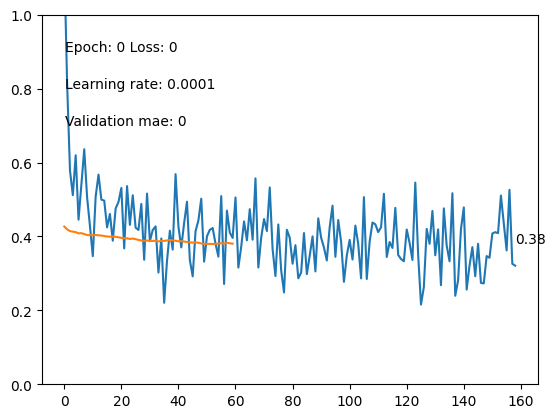

In [34]:
train(
    diffusion_imputer, 
    data_loader_model, 
    data_loader_validation,
    epochs = 30, 
    lr = 0.0001, 
    loss_func = diffusion_imputer.loss_func,
    validation_frequency=1,
    validation_prp=23)

In [ ]:
#save the entire model for further training
#torch.save(diffusion_imputer, "/work/postresearch/Shared/Projects/Farbod/diffusion_imputer_forecast_last_4.pt")
#torch.save(diffusion_imputer, "/work/postresearch/Shared/Projects/Farbod/diffusion_imputer_27.pt")


In [83]:
132710400/(50* 36* 36* 1024)

2.0

# Evaluation for random imputation

In [120]:
diffusion_imputer = torch.load("/work/postresearch/Shared/Projects/Farbod/diffusion_imputer_27.pt")

In [27]:
num_batch_test = 82
data_loaders = get_dataloader(num_batch_test, "cuda")
data_loader_test = get_dataloader(num_batch_test, "cuda")[2]

In [28]:
trn_std = data_loaders[3]
trn_mean = data_loaders[4]

In [29]:
prp = 0.1

for i, batch in enumerate(data_loader_test):
    test_data = batch["observed_data"]

imputation_mask = torch.zeros_like(test_data)
random_mask = torch.rand_like(test_data)
imputation_mask[random_mask <= prp] = 1

"""imputation_indices = np.arange(test_data.shape[1]-1, int((1-prp)*test_data.shape[1])-1, -1)
imputation_mask = torch.zeros_like(test_data)
imputation_mask[:, imputation_indices] = 1"""

given_points = test_data * (1-imputation_mask)

eval_points = test_data * imputation_mask

In [30]:
print(torch.sum(given_points!=0))
print(torch.sum(eval_points!=0))

tensor(87445)
tensor(9679)


In [31]:
sample_number = 100
samples = []
for i in range(sample_number):
    samples.append(diffusion_imputer.eval(test_data.to("cuda"), imputation_mask.to("cuda")))

mae =  0.14818207958535232
mae =  0.14876220063283538
mae =  0.14874307434439682
mae =  0.1490994006782864
mae =  0.1497729617028375
mae =  0.14875486168161003
mae =  0.14812505642341267
mae =  0.1502022732866152
mae =  0.15168139730342686
mae =  0.1474678959761397
mae =  0.14542211865982266
mae =  0.14662022855253976
mae =  0.14939145102907736
mae =  0.14705269364027368
mae =  0.14813115914807384
mae =  0.1490599903219611
mae =  0.1479185936759649
mae =  0.1485068539258197
mae =  0.1481316401405247
mae =  0.14692099654287202
mae =  0.1496526800624248
mae =  0.14767988315545622
mae =  0.1478466936522567
mae =  0.14692166977556753
mae =  0.1515536923990154
mae =  0.1450522516875495
mae =  0.14872204055943522
mae =  0.14976129305485783
mae =  0.14798564572492934
mae =  0.1473309730539553
mae =  0.1476546270850732
mae =  0.1508914107171489
mae =  0.14837632729474373
mae =  0.1473136787263162
mae =  0.14906187422782569
mae =  0.15174010951080502
mae =  0.14999924484531985
mae =  0.14913470

KeyboardInterrupt: 

In [32]:
imputation_results = [samples[i][0] for i in range(len(samples))] # = imputation results, input data, mask, mae

In [33]:
torch.mean(imputation_results[0])

tensor(-0.1807, device='cuda:0', dtype=torch.float64)

In [34]:
imputation_results = [result * trn_std + trn_mean for result in imputation_results]

In [35]:
torch.mean(imputation_results[0])

tensor(74.3423, device='cuda:0', dtype=torch.float64)

In [36]:
denormed_data = test_data * trn_std.to("cpu") + trn_mean.to("cpu")

In [37]:
qlist = [0.05,0.25,0.5,0.75,0.95]
quantiles_imp= []
for q in qlist:
    quantiles = torch.quantile(torch.stack(imputation_results), q, dim=0)
    quantiles_imp.append(quantiles.cpu().numpy() * (imputation_mask).cpu().numpy() + (denormed_data * (1 - imputation_mask)).cpu().numpy())

In [38]:
print(quantiles_imp[0].shape)

(82, 36, 36)


In [39]:
"""maes = []
for i in range(sample_number):
  raw = samples[0][1] * trn_std + trn_mean
  imputed = samples[0][0] * trn_std + trn_mean
  maes.append(torch.mean(torch.abs(raw[imputation_mask !=0] - imputed[imputation_mask !=0])).item())
print(sum(maes) / sample_number)"""  # WRONG

mae = torch.mean(torch.abs(denormed_data[imputation_mask != 0] - torch.Tensor(quantiles_imp[2][imputation_mask != 0]))).item()
print(mae)

8.539712104975635


In [40]:
def quantile_loss(target, forecast, q: float, eval_points) -> float:
    return 2 * torch.sum(
        torch.abs((forecast - target) * eval_points * ((target <= forecast) * 1.0 - q))
    )


def calc_denominator(target, eval_points):
    return torch.sum(torch.abs(target * eval_points))


def calc_quantile_CRPS(target, forecast, eval_points, mean_scaler, scaler):
    target = target * scaler + mean_scaler
    forecast = forecast * scaler + mean_scaler

    quantiles = np.arange(0.05, 1.0, 0.05)
    denom = calc_denominator(target, eval_points)
    CRPS = 0
    for i in range(len(quantiles)):
        q_pred = []
        for j in range(len(forecast)):
            q_pred.append(torch.quantile(forecast[j : j + 1], quantiles[i], dim=1))
        q_pred = torch.cat(q_pred, 0)
        q_loss = quantile_loss(target, q_pred, quantiles[i], eval_points)
        CRPS += q_loss / denom
    return CRPS.item() / len(quantiles)


In [42]:
sample_number = 62

In [44]:
all_target = samples[0][1]  # input_data same for all samples (B, L, K)
all_generated_samples = torch.stack([samples[i][0] for i in range(sample_number)]).permute(1,0,2,3)  # (B, sample_num, L, K)
all_evalpoint = samples[0][2]  # mask same for all samples (B, L, K)
CRPS = calc_quantile_CRPS(all_target, all_generated_samples, all_evalpoint, trn_mean, trn_std)
print(CRPS)

0.08685320877798076


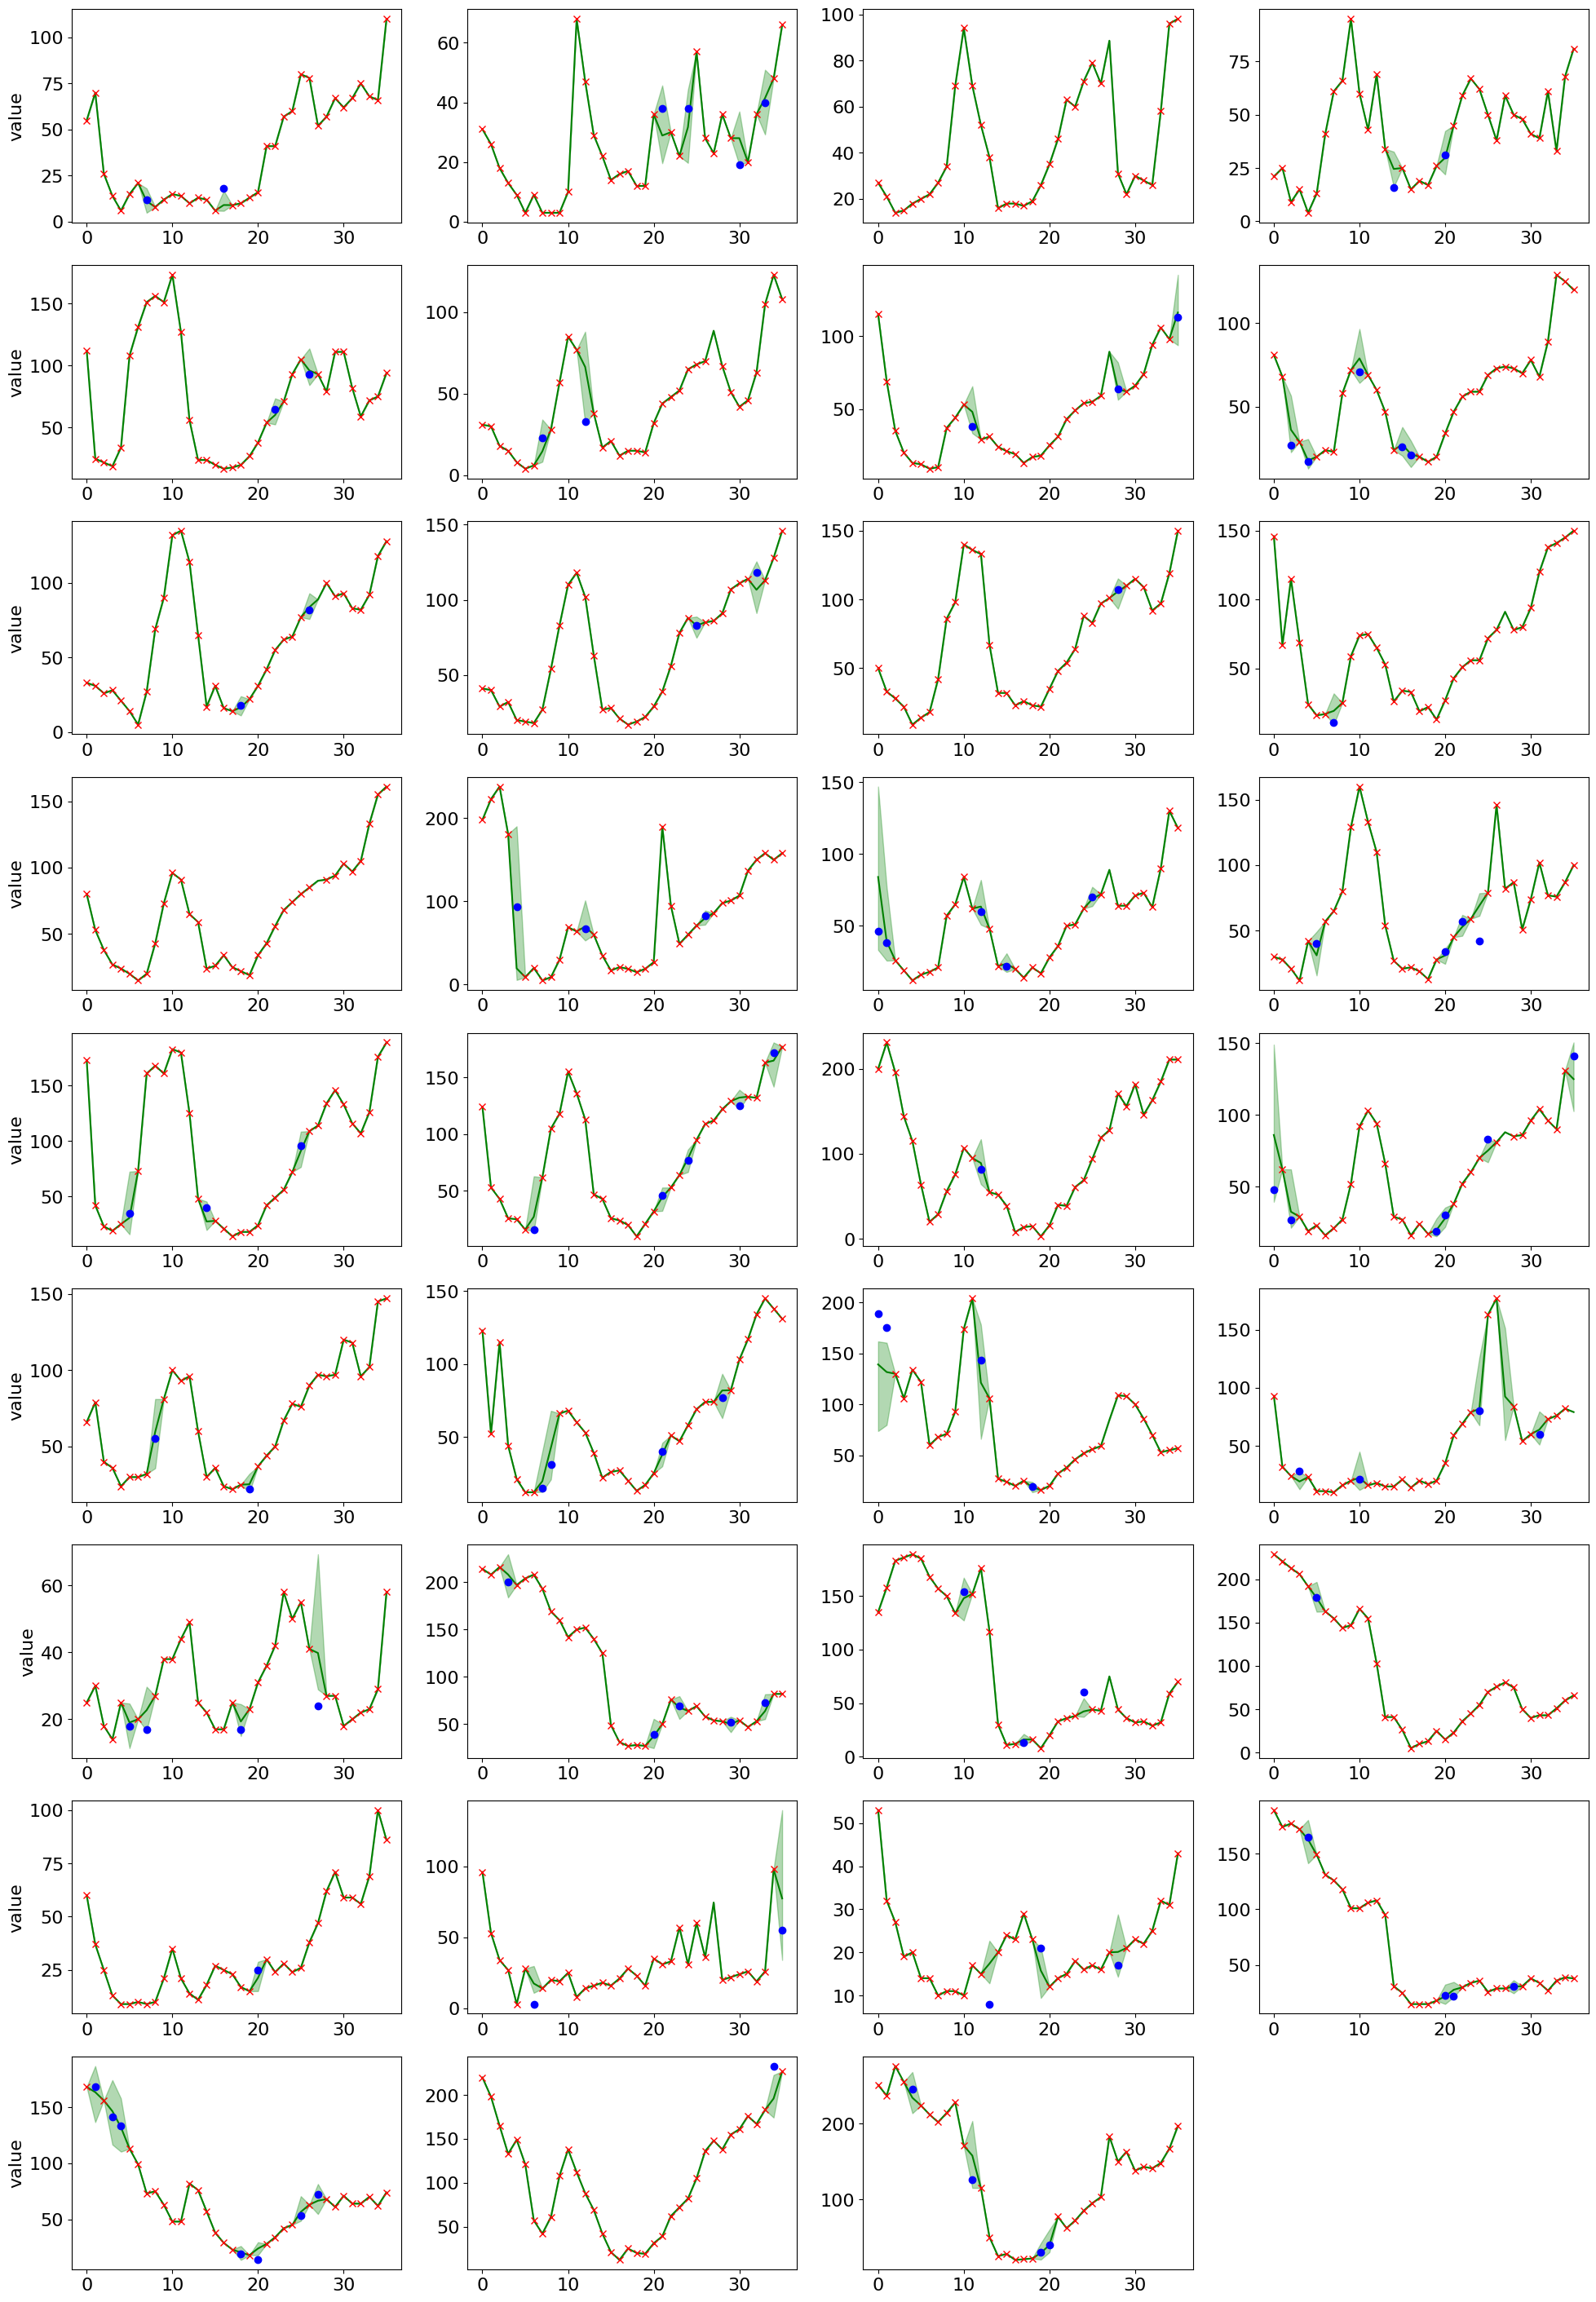

In [50]:
L = test_data.shape[1]
K = test_data.shape[2]

###airquality###
dataind = 0 #change to visualize a different sample in the batch

plt.rcParams["font.size"] = 16
fig, axes = plt.subplots(nrows=9, ncols=4,figsize=(24.0, 36.0))
fig.delaxes(axes[-1][-1])

for k in range(K):
    df = pd.DataFrame({"x":np.arange(0,L), "val":denormed_data[dataind,:,k], "y":eval_points[dataind,:,k]})
    df = df[df.y != 0]
    df2 = pd.DataFrame({"x":np.arange(0,L), "val":denormed_data[dataind,:,k], "y":given_points[dataind,:,k]})
    df2 = df2[df2.y != 0]
    row = k // 4
    col = k % 4
    #axes[row][col].plot(imputation_indices, quantiles_imp[2][dataind, imputation_indices, k], color = 'g', marker='x', linestyle='None')
    axes[row][col].plot(range(0,L), quantiles_imp[2][dataind,:,k], color = 'g',linestyle='solid',label='median')
    axes[row][col].fill_between(range(0,L), quantiles_imp[0][dataind,:,k],quantiles_imp[4][dataind,:,k],
                    color='g', alpha=0.3)
    axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='None')
    axes[row][col].plot(df2.x,df2.val, color = 'r',marker = 'x', linestyle='None')
    if col == 0:
        plt.setp(axes[row, 0], ylabel='value')
    if row == -1:
        plt.setp(axes[-1, col], xlabel='time')

# Medicare data

In [140]:
# read the data csv
data = pd.read_csv("/work/postresearch/Shared/Projects/Farbod/clustering_physicians/sample_for_imputation.csv")
data = data.drop(columns = ["Unnamed: 0", "county", "state", "BENE_STATE_CD"])
#see the first 5 rows
data.head()

,DESY_SORT_KEY,CLM_THRU_DT,GNDR_CD,BENE_RACE_CD,CLM_PMT_AMT,ICD_DGNS_CD1,ICD_DGNS_CD2,ICD_DGNS_CD3,ICD_DGNS_CD4,ICD_DGNS_CD5,...,ICD_DGNS_CD10,ICD_PRCDR_CD1,sex,race,age,died_2016,died_2017,died_2018,died_2019,died_2020
0,100000203,20160403,2,1,6110.17,J189,E871,I509,F329,F419,...,K449,BB241ZZ,2,1,68,False,False,False,False,False
1,100000421,20160617,2,1,26010.55,T84020A,T84090A,F952,E559,I071,...,M1990,0SR901Z,2,1,45,False,False,False,False,False
2,100000905,20160920,2,1,4354.34,N132,K760,E119,N3000,B9620,...,R9431,0T768DZ,2,1,79,False,False,False,False,False
3,100000905,20161015,2,1,7344.59,J189,J90,E119,R630,Z936,...,J45909,0,2,1,79,False,False,False,False,False
4,100000945,20160226,1,1,25869.46,N132,G912,N179,I739,N3281,...,0,0TC78ZZ,1,1,80,False,False,False,False,False


In [141]:
data.shape

(564276, 24)

In [142]:
#print column names
data.columns

Index(['DESY_SORT_KEY', 'CLM_THRU_DT', 'GNDR_CD', 'BENE_RACE_CD',
       'CLM_PMT_AMT', 'ICD_DGNS_CD1', 'ICD_DGNS_CD2', 'ICD_DGNS_CD3',
       'ICD_DGNS_CD4', 'ICD_DGNS_CD5', 'ICD_DGNS_CD6', 'ICD_DGNS_CD7',
       'ICD_DGNS_CD8', 'ICD_DGNS_CD9', 'ICD_DGNS_CD10', 'ICD_PRCDR_CD1', 'sex',
       'race', 'age', 'died_2016', 'died_2017', 'died_2018', 'died_2019',
       'died_2020'],
      dtype='object')

In [143]:
#set GNDR_CD, BENE_RACE_CD, BENE_STATE_CD, state, county, sex, race as object

data["GNDR_CD"] = data["GNDR_CD"].astype(object)
data["BENE_RACE_CD"] = data["BENE_RACE_CD"].astype(object)
#data["BENE_STATE_CD"] = data["BENE_STATE_CD"].astype(object)
# data["state"] = data["state"].astype(object)
# data["county"] = data["county"].astype(object)
data["sex"] = data["sex"].astype(object)



In [144]:
#find the categorical columns
categorical_columns = []
for column in data.columns:
    if data[column].dtype == object:
        categorical_columns.append(column)
print(categorical_columns)



['GNDR_CD', 'BENE_RACE_CD', 'ICD_DGNS_CD1', 'ICD_DGNS_CD2', 'ICD_DGNS_CD3', 'ICD_DGNS_CD4', 'ICD_DGNS_CD5', 'ICD_DGNS_CD6', 'ICD_DGNS_CD7', 'ICD_DGNS_CD8', 'ICD_DGNS_CD9', 'ICD_DGNS_CD10', 'ICD_PRCDR_CD1', 'sex']


In [145]:
#set the date column as datetime, it's formatted like this 20160403
data["date"] = pd.to_datetime(data["CLM_THRU_DT"], format = "%Y%m%d")
#create a variable for the month
data["month"] = data["date"].dt.month

In [146]:
#create a vocabulary for the categorical columns
categorical_vocab = {}
for column in categorical_columns:
    categorical_vocab[column] = data[column].unique()
print(categorical_vocab)

# replace the categorical columns with their indices
for column in categorical_columns:
    data[column] = data[column].apply(lambda x: np.where(categorical_vocab[column] == x)[0][0])
    print(column + " is done")



{'GNDR_CD': array([2, 1], dtype=object), 'BENE_RACE_CD': array([1, 4, 2, 5, 0, 3, 6], dtype=object), 'ICD_DGNS_CD1': array(['J189', 'T84020A', 'N132', ..., 'S0281XD', 'Q620', 'I409'],
      dtype=object), 'ICD_DGNS_CD2': array(['E871', 'T84090A', 'K760', ..., 'H53459', 'S34101S', 'H53122'],
      dtype=object), 'ICD_DGNS_CD3': array(['I509', 'F952', 'E119', ..., 'T461X1A', 'I401', 'N343'],
      dtype=object), 'ICD_DGNS_CD4': array(['F329', 'E559', 'N3000', ..., 'S60032A', 'F13129', 'H5350'],
      dtype=object), 'ICD_DGNS_CD5': array(['F419', 'I071', 'B9620', ..., 'T433X5D', 'I401', 'S06820A'],
      dtype=object), 'ICD_DGNS_CD6': array(['E785', 'M419', 'E039', ..., 'O99284', 'S06319D', 'B1009'],
      dtype=object), 'ICD_DGNS_CD7': array(['K219', 'Z96642', 'N8320', ..., 'S41011A', 'S12030D', 'T85848A'],
      dtype=object), 'ICD_DGNS_CD8': array(['I10', 'E780', 'R600', ..., 'S4981XA', 'S22019D', 'S22019A'],
      dtype=object), 'ICD_DGNS_CD9': array(['A084', 'J45909', 'R0789', ..., '

In [147]:
# save the categorical vocab
with open("/work/postresearch/Shared/Projects/Farbod/clustering_physicians/categorical_vocab.pickle", "wb") as f:
    pickle.dump(categorical_vocab, f, protocol=pickle.HIGHEST_PROTOCOL)

#save the data
data.to_csv("/work/postresearch/Shared/Projects/Farbod/clustering_physicians/data_for_imputation.csv")

In [449]:
data = pd.read_csv("/work/postresearch/Shared/Projects/Farbod/clustering_physicians/data_for_imputation.csv")
data = data.drop(columns = ["Unnamed: 0"])

In [450]:
#turn all the columns into floats (dropping the date column and CLM_THRU_DT)
data = data.drop(columns = ["date", "CLM_THRU_DT"])
data = data.astype(float)

In [451]:
data_for_imputation = data.copy()
data_for_imputation.head()

,DESY_SORT_KEY,GNDR_CD,BENE_RACE_CD,CLM_PMT_AMT,ICD_DGNS_CD1,ICD_DGNS_CD2,ICD_DGNS_CD3,ICD_DGNS_CD4,ICD_DGNS_CD5,ICD_DGNS_CD6,...,ICD_PRCDR_CD1,sex,race,age,died_2016,died_2017,died_2018,died_2019,died_2020,month
0,100000203.0,0.0,0.0,6110.17,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,68.0,0.0,0.0,0.0,0.0,0.0,4.0
1,100000421.0,0.0,0.0,26010.55,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,45.0,0.0,0.0,0.0,0.0,0.0,6.0
2,100000905.0,0.0,0.0,4354.34,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,0.0,1.0,79.0,0.0,0.0,0.0,0.0,0.0,9.0
3,100000905.0,0.0,0.0,7344.59,0.0,3.0,2.0,3.0,3.0,3.0,...,3.0,0.0,1.0,79.0,0.0,0.0,0.0,0.0,0.0,10.0
4,100000945.0,1.0,0.0,25869.46,2.0,4.0,3.0,4.0,4.0,4.0,...,4.0,1.0,1.0,80.0,0.0,0.0,0.0,0.0,0.0,2.0


In [452]:
#sort by DESY_SORT_KEY and month
data_for_imputation = data_for_imputation.sort_values(by = ["DESY_SORT_KEY", "month"])
#keep only one observation per DESY_SORT_KEY and month
data_for_imputation = data_for_imputation.drop_duplicates(subset = ["DESY_SORT_KEY", "month"])
#only keep people with at least 6 months of data
data_for_imputation = data_for_imputation.groupby("DESY_SORT_KEY").filter(lambda x: len(x) >= 6)
data_for_imputation["died_overall"] = data_for_imputation["died_2016"] + data_for_imputation["died_2017"] + data_for_imputation["died_2018"] + data_for_imputation["died_2019"] + data_for_imputation["died_2020"]
data_for_imputation["died_2016_2017"] = data_for_imputation["died_2016"] + data_for_imputation["died_2017"]
data_for_imputation["died_overall"] = data_for_imputation["died_overall"].apply(lambda x: 1 if x > 0 else 0)
data_for_imputation["died_2016_2017"] = data_for_imputation["died_2016_2017"].apply(lambda x: 1 if x > 0 else 0)
#create columns of all zeros for months that a DESY_SORT_KEY is not present
death_data = data_for_imputation[["DESY_SORT_KEY", "died_overall"]]#, "died_2016_2017"]]
#choose only unique rows in death_data
death_data = death_data.drop_duplicates(subset = ["DESY_SORT_KEY"])
data_for_imputation = data_for_imputation.drop(columns = ["died_overall", "died_2016_2017", "died_2016", "died_2017", "died_2018", "died_2019", "died_2020"])
data_for_imputation = data_for_imputation.set_index(["DESY_SORT_KEY", "month"]).unstack(fill_value = 0).stack().reset_index()
#merge the death data back in and if unavailable, fill with 0
data_for_imputation = data_for_imputation.merge(death_data, how = "left", on = ["DESY_SORT_KEY"])
data_for_imputation["died_overall"] = data_for_imputation["died_overall"].fillna(0)
#data_for_imputation["died_2016_2017"] = data_for_imputation["died_2016_2017"].fillna(0)
#sort by DESY_SORT_KEY again
data_for_imputation = data_for_imputation.sort_values(by = ["DESY_SORT_KEY", "month"])
#add a column for died overall based on the last 5 columns

data_for_imputation.head()

,DESY_SORT_KEY,month,GNDR_CD,BENE_RACE_CD,CLM_PMT_AMT,ICD_DGNS_CD1,ICD_DGNS_CD2,ICD_DGNS_CD3,ICD_DGNS_CD4,ICD_DGNS_CD5,ICD_DGNS_CD6,ICD_DGNS_CD7,ICD_DGNS_CD8,ICD_DGNS_CD9,ICD_DGNS_CD10,ICD_PRCDR_CD1,sex,race,age,died_overall
0,100041295.0,1.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,100041295.0,2.0,0.0,0.0,17827.84,186.0,143.0,166.0,67.0,36.0,146.0,149.0,152.0,23.0,26.0,118.0,0.0,1.0,80.0,1
2,100041295.0,3.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,100041295.0,4.0,0.0,0.0,7122.15,186.0,144.0,167.0,5.0,167.0,3.0,37.0,15.0,51.0,96.0,3.0,0.0,1.0,80.0,1
4,100041295.0,5.0,0.0,0.0,18458.00,79.0,54.0,168.0,28.0,33.0,147.0,37.0,0.0,19.0,20.0,105.0,0.0,1.0,80.0,1


In [453]:
data_for_imputation.shape

(38976, 20)

In [454]:
#number of unique DESY_SORT_KEYs
len(data_for_imputation["DESY_SORT_KEY"].unique())

3248

In [455]:
#number of columns
len(data_for_imputation.columns)

20

In [456]:
#nomrlaize the data
data_for_imputation = data_for_imputation.drop(columns = ["DESY_SORT_KEY", "month"])
#save the mean and std
train_mean = data_for_imputation.mean()
train_std = data_for_imputation.std()

#normalize the data
# data_for_imputation = (data_for_imputation - train_mean) / train_std

In [457]:
#create tensor
data_for_imputation_tensor = torch.tensor(data_for_imputation.values).reshape(3248, 12, -1)
print(data_for_imputation_tensor.shape)
#turn of pytorch scientific notation
torch.set_printoptions(profile="full", sci_mode=False)
#see the first 5 rows
data_for_imputation_tensor[6, 0, :]


torch.Size([3248, 12, 18])


tensor([    1.0000,     0.0000, 13537.2200,   486.0000,    22.0000,   434.0000,
          432.0000,   457.0000,   326.0000,    62.0000,   396.0000,    55.0000,
          358.0000,   326.0000,     1.0000,     1.0000,    43.0000,     1.0000],
       dtype=torch.float64)

In [458]:
#save the tensor
torch.save(data_for_imputation_tensor, "/work/postresearch/Shared/Projects/Farbod/clustering_physicians/data_for_imputation_tensor.pt")

In [18]:
data_for_imputation_tensor = torch.load("/work/postresearch/Shared/Projects/Farbod/clustering_physicians/data_for_imputation_tensor.pt")

In [19]:
#train val test split using the first dimension
train_data, val_data, test_data = torch.utils.data.random_split(data_for_imputation_tensor, [int(0.8 * data_for_imputation_tensor.shape[0]), int(0.1 * data_for_imputation_tensor.shape[0])+1, int(0.1 * data_for_imputation_tensor.shape[0])+1])

In [22]:
#create data loader for train, val, and test 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

#check the size of the train, val, and test sets
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

52
325
325


In [23]:
#create a train function that also shows a dynamic loss plot. It should also be batched. 
#the plot should be dynamic and show the loss for each epoch.
%matplotlib inline
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import time

def train(model, data_loader, data_loader_validation, epochs, lr, loss_func, device = "cuda", verbose = True, validation_frequency = 1, validation_prp = 10, strategy = "random"):

    model = model.to(device)
    #annealing for the learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    loss_list = []
    fig = plt.figure()
    ax = fig.add_subplot(111)
    epoch_loss = 0
    epoch_loss_list = []
    mae = 0
    for epoch in range(epochs):
        
        #annealing for the learning rate (if the loss has not decreased in the last 2 epochs, divide the learning rate by 2)
        if epoch > 3:
            if epoch_loss >= min(epoch_loss_list[-3:]):
                for g in optimizer.param_groups:
                    g['lr'] = g['lr'] / 2

        start = time.time()
        for i, batch in enumerate(data_loader):
            optimizer.zero_grad()
            predicted_noise, noise, noise_mask = model(batch.to(device))
            loss = loss_func(predicted_noise, noise, noise_mask)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
            if i % 2 == 0:       
                ax.clear()
                ax.set_ylim(0, 1)
                ax.plot(loss_list)
                #ax.text(len(loss_list) - 1, loss_list[-1], str(round(loss_list[-1], 3)))
                #add a smooth line to the plot every 100 steps
                if len(loss_list) > 100:
                    ax.plot(np.convolve(loss_list, np.ones((100,))/100, mode='valid'))
                    #show the last loss value on the plot
                    ax.text(len(loss_list) - 1, np.convolve(loss_list, np.ones((100,))/100, mode='valid')[-1],
                             str(round(np.convolve(loss_list, np.ones((100,))/100, mode='valid')[-1], 3)))
                ax.text(0.1, 0.9, "Epoch: " + str(epoch) + " Loss: " + str(round(epoch_loss, 3)))
                ax.text(0.1, 0.8, "Learning rate: " + str(round(optimizer.param_groups[0]['lr'], 9)))
                ax.text(0.1, 0.7, "Validation mae: " + str(round(mae, 3)))
                display(fig)
                clear_output(wait=True)
            #print("Epoch: ", epoch, "Loss: ", loss.item())
        end = time.time()    
        
        if verbose:
            #add the epoch average loss to the plot
            #find the number of batches in the epoch
            num_batches = len(data_loader)
            #find the average loss for the epoch
            epoch_loss = sum(loss_list[-num_batches:]) / num_batches
            epoch_loss_list.append(epoch_loss)
        
        #validation at the end of each n epoch

        if epoch % validation_frequency == 0:
            imputed_samples = torch.tensor([]).to("cuda")
            data = torch.tensor([]).to("cuda")
            imputation_mask = torch.tensor([]).to("cuda")
            mae_list = []
            
            for i, batch in enumerate(data_loader_validation):
                if i % validation_prp == 0:
                    test_data = batch.to("cuda")
                    imputation_mask = diffusion_imputation.get_mask(model, test_data, strategy).to("cuda")
                    imputed_step, data_step, imputation_mask_step, mae_step = diffusion_imputation.eval(model, test_data, imputation_mask, verbose=False)
                    imputed_samples = torch.cat((imputed_samples, imputed_step), dim = 0)
                    data = torch.cat((data, data_step), dim = 0)
                    imputation_mask = torch.cat((imputation_mask, imputation_mask_step), dim = 0)
                    mae_list.append(mae_step)
            mae = sum(mae_list) / len(mae_list)


    return(model, loss_list)

In [44]:
diffusion_imputer_medicare = diffusion_imputation(
    emb_dim = 128,
    strategy='death_prediction',
    num_residual_layers=4,
    missing_prp= 0.1,
    diffusion_steps= 50,
    #diffusion_beta_schedule= "death",
    num_heads=8,
    ff_dim=1024,
    num_cells = 1,
    dropout=0.1,
    device="cuda")

# data = torch.ones((10,10,10)).to("cuda")
# diffusion_imputer(data, strategy='random')

/tmp/ipykernel_15779/1645569926.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.alpha_torch = torch.tensor(self.alpha).float()


KeyboardInterrupt: 

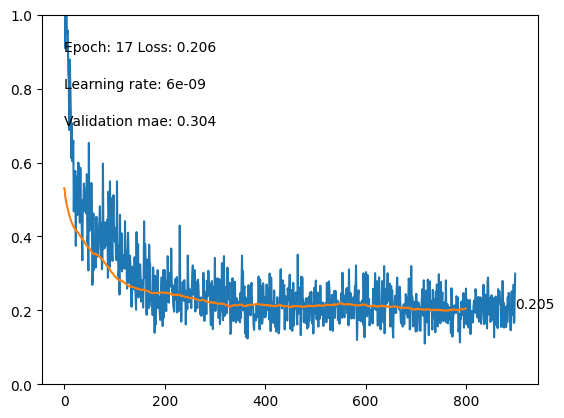

In [45]:
train(
    diffusion_imputer_medicare, 
    train_loader, 
    val_loader,
    epochs = 20, 
    lr = 0.0001, 
    loss_func = diffusion_imputer_medicare.loss_func,
    validation_frequency=1,
    validation_prp=50,
    strategy = "death_prediction")

# Evaluation

In [53]:
#let's try to impute the data
imputed_samples_from_loop = torch.tensor([]).to("cuda")
data_from_loop = torch.tensor([]).to("cuda")
#imputation_mask_from_loop = torch.tensor([]).to("cuda")

data_shape = (1, 12, 18)
zeros_for_shape = torch.zeros(data_shape).to("cuda")
        
imputation_mask = diffusion_imputation.get_mask(diffusion_imputer_medicare, zeros_for_shape, "death_prediction").to("cuda")

for i in range(1):
    imputed_samples = torch.tensor([]).to("cuda")
    data = torch.tensor([]).to("cuda")
    #imputation_mask = torch.tensor([]).to("cuda")
    
    for i, batch in enumerate(test_loader):
                test_data = batch.to("cuda")
                imputed_step, data_step, imputation_mask, mae = diffusion_imputation.eval(diffusion_imputer_medicare, test_data, imputation_mask)
                imputed_samples = torch.cat((imputed_samples, imputed_step), dim = 0)
                data = torch.cat((data, data_step), dim = 0)
                #imputation_mask = torch.cat((imputation_mask, imputation_mask_step), dim = 0)

    imputed_samples_from_loop = torch.cat((imputed_samples_from_loop, imputed_samples), dim = 0)
    data_from_loop = torch.cat((data_from_loop, data), dim = 0)
    #imputation_mask_from_loop = torch.cat((imputation_mask_from_loop, imputation_mask), dim = 0)

mae =  0.23498117427031198
mae =  0.6929985086123148
mae =  0.3649946550528208
mae =  0.5384741506228844
mae =  0.8882415344317753
mae =  0.29695461938778556
mae =  0.3016527611762285
mae =  0.4294669007261594
mae =  0.15261895954608917
mae =  0.26557940741380054
mae =  0.33037797609965003
mae =  0.8121302301685015
mae =  0.3247257173061371
mae =  0.6574115784217913
mae =  0.9573225552837054
mae =  0.34702525784571964
mae =  0.6388011400898297
mae =  0.35833399991194403
mae =  0.8257750744620959
mae =  0.3664796141286691
mae =  0.3475465749700864
mae =  0.8426788585881392
mae =  0.9768656765421231
mae =  0.33907398395240307
mae =  0.2516924018661181
mae =  0.7398839816451073
mae =  0.8971065084139506
mae =  0.2061053365468979
mae =  0.7540995702147484
mae =  0.43441886578996974
mae =  0.2656468451023102
mae =  0.5904316802819569
mae =  0.20962350815534592
mae =  0.26696526383360225
mae =  0.32442524035771686
mae =  0.38918651392062503
mae =  0.2895506074031194
mae =  0.825119453171889


KeyboardInterrupt: 

In [94]:
a = torch.tensor(imputed_samples).to("cuda")
a=torch.median(a[:,:,-1], dim = 1).values
a
#torch.max(a.values, dim = 1).values

/tmp/ipykernel_15779/2850222367.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch.tensor(imputed_samples).to("cuda")


tensor([0.7900, 0.7192, 0.7677, 0.4796, 0.8339, 0.7612, 0.8321, 0.6063, 0.8277,
        0.7260, 0.9166, 0.7891, 0.7764, 0.6599, 0.8561, 0.7947, 0.6224, 0.6529,
        0.8521, 0.7888, 0.6654, 0.7903, 1.0986, 0.7223, 0.7036, 0.7822, 0.8059,
        0.9931, 0.7826, 0.7003, 0.7065, 0.5532, 0.9104, 1.0636, 0.7139, 0.7524,
        0.8378, 0.7631, 0.5681, 0.8110, 0.7806, 0.7742, 0.9169, 0.5696, 0.8804,
        0.7043, 0.8279, 0.7235, 0.6111, 0.7112, 0.5199, 0.8512, 0.7956, 0.8870,
        0.8959, 1.0242, 0.8813, 0.8063, 0.7682, 0.7879, 0.7415, 0.7254, 1.0492,
        0.7510, 0.8817, 0.9781, 0.9030, 0.7612, 0.7259, 0.4337, 0.7924, 0.5222,
        0.7995, 0.8604, 0.7747, 0.7359, 0.8997, 0.9515, 0.8465, 0.8513, 0.7303,
        0.5924, 0.7410, 0.8437, 0.8913, 0.8909, 0.8965, 0.9020, 0.7843, 0.7627,
        0.9156, 0.9541, 0.5100, 0.6092, 0.6652, 0.9140, 0.5987, 0.8340, 0.7311,
        0.8642, 0.8210, 0.6686, 0.8216, 0.9078, 0.8003, 0.8360, 0.6926, 0.4721,
        0.6540, 0.8403, 0.9298, 0.6984, 

In [55]:
# #demean
# a = torch.tensor(imputed_samples).to("cuda") * torch.tensor(train_std).to("cuda") + torch.tensor(train_mean).to("cuda")
# a=torch.mean(a[:,:,-1], dim = 1)
# a.round()

In [96]:
b = torch.mean(data[:,:,-1], dim=1).to("cuda")
b.values
b
#torch.max(a.values, dim=1).values

tensor([1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1.,
        0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
        1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
        1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
        1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
        0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1.,
        1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
        1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1.,
        0., 1., 1., 1., 1., 1., 0., 1.],

In [97]:
# b = torch.tensor(data).to("cuda") * torch.tensor(train_std).to("cuda") + torch.tensor(train_mean).to("cuda")
# b = torch.mean(b[:,:,-1], dim = 1)
# b

In [98]:
c=[a.tolist(),b.tolist()]

#make c dataframe
c = pd.DataFrame(c).T
#find the sensitivity and specificity
c[0] = c[0]>0.5
c[0] = c[0].astype(int)
c[1] = c[1].astype(int)
c[2] = c[0] == c[1]
c[2] = c[2].astype(int)
c[2].value_counts()
print(c[2].value_counts()[1]/(c[2].value_counts()[1]+c[2].value_counts()[0]))
print(c[2].value_counts()[0]/(c[2].value_counts()[1]+c[2].value_counts()[0]))


0.6339285714285714
0.36607142857142855


In [ ]:
imputation_mask = imputation_mask.repeat(len(test_set), 1, 1)

In [ ]:
#find the medians in the imputed samples
imputed_samples = imputed_samples_from_loop.reshape(1, -1, 36, 36)
data = data_from_loop.reshape(1, -1, 36, 36)

#find the medians in the imputed samples
imputed_samples = torch.mean(imputed_samples, dim = 0).squeeze(0)
data = torch.mean(data, dim = 0).squeeze(0)
